In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.interpolate import interp1d

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

def extract_numbers(filename):
    """파일 이름에서 실험 번호와 샘플 번호를 추출합니다.

    Args:
        filename (str): 파일 이름 (예: 'T1_1_Expt_1_2.csv')

    Returns:
        tuple: 추출된 숫자들 (T 번호, 샘플 번호, 실험 번호 1, 실험 번호 2)을 정수 형태로 반환합니다.
        None: 파일 이름이 형식에 맞지 않으면 None을 반환합니다.
    """
    """Extract numbers from filename: 'T#_#_Expt_#_#.csv'"""
    match = re.match(r'T(\d+)_(\d+)_Expt_(\d+)_(\d+).csv', filename)
    if match:
        T, S, E, _ = map(int, match.groups())
        return T, S, E
    print('No match')
    return None


def combine_data(dir_path, Tnum, sensor='Accelerometer'):
    """주어진 디렉토리에서 특정 센서 데이터를 통합하여 DataFrame으로 반환합니다.

    Args:
        dir_path (str): 데이터 파일이 저장된 디렉토리 경로
        Tnum (str): 실험 번호 디렉토리 (예: 'T1')
        sensor (str): 센서 유형 (예: 'Accelerometer', 기본값: 'Accelerometer')

    Returns:
        pandas.DataFrame: 통합된 센서 데이터
    """
    dfs = []
    path = os.path.join(dir_path, Tnum, sensor)
    if os.path.exists(path):
        sorted_files = sorted(os.listdir(
            path), key=lambda x: extract_numbers(x))
        for file in sorted_files:
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(path, file))
                _, S, E = extract_numbers(file)
                df['sample'] = S
                df['Expt'] = E

                dfs.append(df)
    else:
        print(f'{path} not found')
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df


def downsampling(ACC, FOR):
    """두 데이터를 동일한 크기와 형태로 맞춰 비교하거나 입력으로 사용할 수 있도록 데이터를 변환

    Args:
        ACC (pandas.DataFrame): 가속도계 데이터
        FOR (pandas.DataFrame): 힘 센서 데이터

    Returns:
        pandas.DataFrame: 다운샘플링된 가속도계 데이터
    """
    dfs = []
    sample_max = int(FOR.iloc[-1]['sample'])  # Maximum sample value in FOR

    for s in range(1, sample_max + 1):
        # Filter data for the current sample
        sample_acc = ACC[ACC['sample'] == s]
        sample_for = FOR[FOR['sample'] == s]

        # Determine lengths for interpolation
        len_acc = len(sample_acc)
        len_for = len(sample_for)
        x = np.linspace(0, 1, len_acc)
        x_new = np.linspace(0, 1, len_for)

        # Drop unnecessary columns and interpolate
        sample_acc = sample_acc.drop(columns=['sample', 'Expt'])
        df = pd.DataFrame(
            {col: np.interp(x_new, x, sample_acc[col]) for col in sample_acc.columns})

        # Append interpolated DataFrame to the list
        dfs.append(df)

    # Concatenate all interpolated DataFrames
    ACC_interp = pd.concat(dfs, ignore_index=True)
    return ACC_interp


class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    
def health_index(scores, th, increase_step=1, decrease_step=0.1):
    """주어진 점수에 기반하여 헬스 지수를 계산합니다. 센서 데이터를 분석하여 건강 상태를 수치로 표현
    
    Args:
        scores (list): 입력 점수 목록
        th (float): 임계값
        increase_step (float): 점수가 임계값을 초과할 때 증가하는 단계 크기 (기본값: 1)
        decrease_step (float): 점수가 임계값 이하일 때 감소하는 단계 크기 (기본값: 0.1)

    Returns:
        list: 계산된 헬스 지수 목록
    """
    state = 0
    state_values = []
    for score in scores:
        if score > th:
            state += increase_step
        else:
            state = max(0, state - decrease_step)  # Ensure state doesn't go below 0
        state_values.append(state)
    return state_values

def stratified_sampling(data, validation_ratio):
    """층화 샘플링(Stratified Sampling)을 사용하여 데이터셋을 훈련 데이터와 검증 데이터로 나눕니다.

    주어진 데이터에서 지정된 검증 비율(validation_ratio)에 따라 데이터의 분포를 유지하며
    그룹화하여 각 그룹에서 무작위로 하나의 샘플을 검증 데이터로 선택합니다.

    Args:
        data (numpy.ndarray): 샘플링할 데이터셋
        validation_ratio (float): 검증 데이터의 비율 (예: 0.2는 전체 데이터의 20%를 검증 데이터로 사용)

    Returns:
        tuple: (train_data, validation_data)
            - train_data (numpy.ndarray): 훈련 데이터
            - validation_data (numpy.ndarray): 검증 데이터
    """
    n_samples = len(data)  # 데이터 전체 개수
    group_size = int(1 / validation_ratio)  # 그룹당 크기 (예: 5개의 데이터 중 1개 선택)
    validation_indices = []

    # 그룹별로 하나씩 샘플링
    for start in range(0, n_samples, group_size):
        group_indices = list(range(start, min(start + group_size, n_samples)))
        if group_indices:
            validation_indices.append(np.random.choice(group_indices))

    # validation 및 train 인덱스 설정
    validation_indices = sorted(validation_indices)
    train_indices = [i for i in range(n_samples) if i not in validation_indices]

    # 데이터 분리 (numpy 배열 인덱싱 사용)
    validation_data = data[validation_indices]
    train_data = data[train_indices]

    return train_data, validation_data


dir_path = '/home/scar/Desktop/sanghoon/crois/data/splitted_100ms'

# load data

In [2]:
Tnum = 'T1'

Tx_acc = combine_data(dir_path, Tnum=Tnum, sensor='Accelerometer')
Tx_for = combine_data(dir_path, Tnum=Tnum, sensor='Force')

Tx_acc_interp = downsampling(Tx_acc, Tx_for)
Tx_for = Tx_for.drop(columns=['sample'])
Tx = pd.concat([Tx_acc_interp, Tx_for], axis=1)

train_slice = Tx[Tx['Expt'].isin([1, 2])].drop(columns=['Expt']).to_numpy()  # Expt 1, 2만 사용

train_slice, val_slice = stratified_sampling(train_slice, 0.15)

scaler = StandardScaler()
train_slice_scaled = scaler.fit_transform(train_slice)
val_slice_scaled = scaler.transform(val_slice)

# model train

In [40]:
# Convert data to PyTorch tensors
X_train = torch.tensor(train_slice_scaled, dtype=torch.float32).cuda()
X_val = torch.tensor(val_slice_scaled, dtype=torch.float32).cuda()

# DataLoader 설정
train_loader = DataLoader(TensorDataset(X_train), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val), batch_size=128, shuffle=False)

# Autoencoder 모델 초기화
input_dim = X_train.shape[1]
model = Autoencoder(input_dim).cuda()

# Loss 함수와 Optimizer 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 학습 및 검증 루프 정의
def train_and_validate(model, train_loader, val_loader, n_epochs=30, early_stop_rounds=10):
    """Autoencoder 모델을 학습하고 검증합니다.

    Args:
        model (nn.Module): 학습할 Autoencoder 모델
        train_loader (DataLoader): 훈련 데이터 로더
        val_loader (DataLoader): 검증 데이터 로더
        optimizer (torch.optim.Optimizer): 옵티마이저
        criterion (nn.Module): 손실 함수
        n_epochs (int): 총 학습 에폭 수 (기본값: 30)
        early_stop_rounds (int): 조기 종료를 위한 검증 손실 허용 에폭 수 (기본값: 10)

    Returns:
        tuple: 훈련 손실 목록과 검증 손실 목록
    """
    best_loss = float('inf')
    train_losses, val_losses = [], []
    stop_counter = 0

    for epoch in range(n_epochs):
        if stop_counter >= early_stop_rounds:
            print("Early stopping triggered.")
            break

        # Training loop
        model.train()
        train_loss_sum = 0
        for batch in train_loader:
            batch_x = batch[0].cuda()
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_x)
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()
        train_loss = train_loss_sum / len(train_loader)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss_sum = 0
        with torch.no_grad():
            for batch in val_loader:
                batch_x = batch[0].cuda()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_x)
                val_loss_sum += loss.item()
        val_loss = val_loss_sum / len(val_loader)
        val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            stop_counter = 0
            print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} (Best model)")
        else:
            stop_counter += 1
            print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Train and validate
print("Training and validating on train_slice and val_slice...")
train_losses, val_losses = train_and_validate(model, train_loader, val_loader)

# 최종 결과 출력
print("\nResults:")
print(f"Training -> Validation: Best Val Loss = {min(val_losses):.4f}")


Training and validating on train_slice and val_slice...
Epoch [1/30], Loss: 0.0443, Val Loss: 0.0162 (Best model)
Epoch [2/30], Loss: 0.0258, Val Loss: 0.0195
Epoch [3/30], Loss: 0.0241, Val Loss: 0.0140 (Best model)
Epoch [4/30], Loss: 0.0223, Val Loss: 0.0168
Epoch [5/30], Loss: 0.0207, Val Loss: 0.0134 (Best model)
Epoch [6/30], Loss: 0.0203, Val Loss: 0.0083 (Best model)
Epoch [7/30], Loss: 0.0188, Val Loss: 0.0114
Epoch [8/30], Loss: 0.0187, Val Loss: 0.0057 (Best model)
Epoch [9/30], Loss: 0.0187, Val Loss: 0.0072
Epoch [10/30], Loss: 0.0168, Val Loss: 0.0057 (Best model)
Epoch [11/30], Loss: 0.0169, Val Loss: 0.0128
Epoch [12/30], Loss: 0.0171, Val Loss: 0.0089
Epoch [13/30], Loss: 0.0166, Val Loss: 0.0068
Epoch [14/30], Loss: 0.0155, Val Loss: 0.0035 (Best model)
Epoch [15/30], Loss: 0.0152, Val Loss: 0.0037
Epoch [16/30], Loss: 0.0141, Val Loss: 0.0034 (Best model)
Epoch [17/30], Loss: 0.0156, Val Loss: 0.0064
Epoch [18/30], Loss: 0.0149, Val Loss: 0.0055
Epoch [19/30], Loss: 

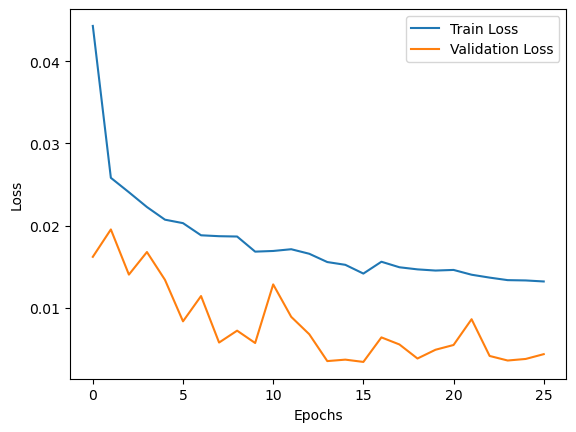

In [41]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
Tnum = 'T1'
T1_acc = combine_data(dir_path, Tnum=Tnum, sensor='Accelerometer')
T1_for = combine_data(dir_path, Tnum=Tnum, sensor='Force')
T1_acc_interp = downsampling(T1_acc, T1_for)
T1_for = T1_for.drop(columns=['sample'])
T1 = pd.concat([T1_acc_interp, T1_for], axis=1)

test_scaled_T1 = scaler.transform(T1.drop(columns=['Expt']).to_numpy())
X_test_T1 = torch.tensor(test_scaled_T1, dtype=torch.float32).cuda()

model.eval()
with torch.no_grad():
    """모델을 평가 모드로 설정하고 테스트 데이터를 기반으로 재구성 오류를 계산합니다.

    이 과정은 Autoencoder 모델이 입력 데이터를 얼마나 정확하게 재구성하는지 확인하기 위해
    원본 데이터와 재구성된 데이터 간의 차이를 계산하여 재구성 오류를 반환합니다.

    Args:
        model (torch.nn.Module): 학습된 Autoencoder 모델
        X_test_T1 (torch.Tensor): 테스트 데이터

    Returns:
        numpy.ndarray: 각 샘플에 대한 평균 재구성 오류 (MSE) 값 배열
    """
    reconstructions_T1 = model(X_test_T1)
    reconstruction_errors_T1 = torch.mean((reconstructions_T1 - X_test_T1) ** 2, dim=1).cpu().numpy()

scores_t1 = reconstruction_errors_T1

In [43]:
Tnum = 'T5'
Tx_acc = combine_data(dir_path, Tnum=Tnum, sensor='Accelerometer')
Tx_for = combine_data(dir_path, Tnum=Tnum, sensor='Force')
Tx_acc_interp = downsampling(Tx_acc, Tx_for)
Tx_for = Tx_for.drop(columns=['sample'])
Tx = pd.concat([Tx_acc_interp, Tx_for], axis=1)

test_scaled = scaler.transform(Tx.drop(columns=['Expt']).to_numpy())
X_test = torch.tensor(test_scaled, dtype=torch.float32).cuda()

model.eval()
with torch.no_grad():
    """모델을 평가 모드로 설정하고 테스트 데이터를 기반으로 재구성 오류를 계산합니다.

    이 과정은 Autoencoder 모델이 입력 데이터를 얼마나 정확하게 재구성하는지 확인하기 위해
    원본 데이터와 재구성된 데이터 간의 차이를 계산하여 재구성 오류를 반환합니다.

    Args:
        model (torch.nn.Module): 학습된 Autoencoder 모델
        X_test_T1 (torch.Tensor): 테스트 데이터

    Returns:
        numpy.ndarray: 각 샘플에 대한 평균 재구성 오류 (MSE) 값 배열
    """
    reconstructions = model(X_test)
    reconstruction_errors = torch.mean((reconstructions - X_test) ** 2, dim=1).cpu().numpy()

scores_t5 = reconstruction_errors

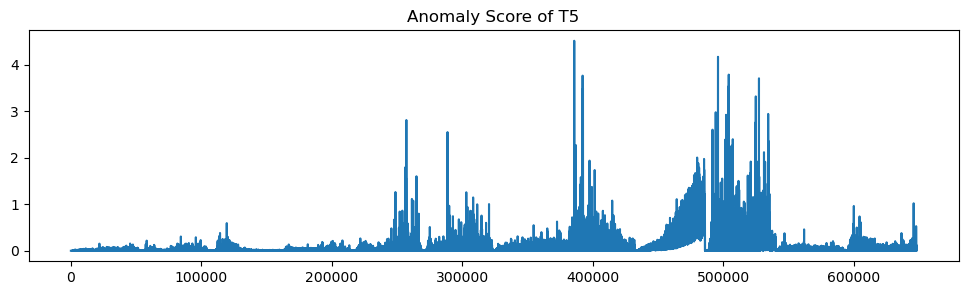

In [44]:
plt.figure(figsize=(12, 3))
plt.plot(scores_t5)
plt.title(f'Anomaly Score of T5')
plt.show()

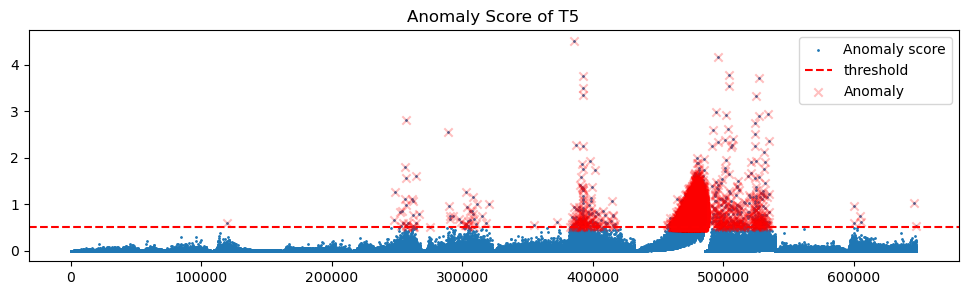

In [45]:
th = 0.5
anomalies = scores_t5 > th
anomaly_indices = np.where(anomalies)[0]
plt.figure(figsize=(12, 3))
plt.scatter(range(len(scores_t5)), scores_t5, s=1, label='Anomaly score')
plt.axhline(y=th, c='red', linestyle='--', label='threshold')
plt.scatter(anomaly_indices, scores_t5[anomaly_indices], marker='x', c='red', alpha=0.25, label='Anomaly')
plt.title(f'Anomaly Score of T5')
plt.legend()
plt.show()

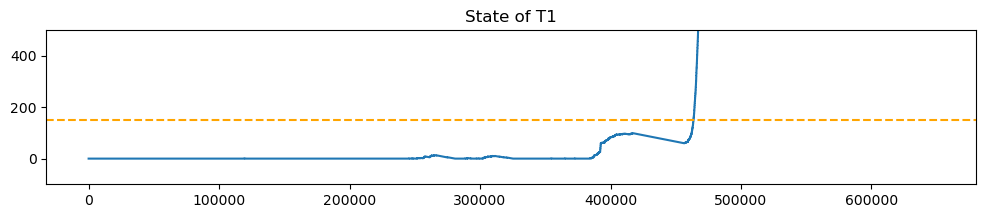

In [51]:
state_t1 = health_index(scores_t1, th=0.5, increase_step=1, decrease_step=0.001)

plt.figure(figsize=(12, 2))
plt.plot(state_t1)
plt.ylim(-100, 500)
plt.axhline(y=150, linestyle='--', c='orange')  # Health index에서 normal vs anomaly `threshold = 100`으로 설정
plt.title(f'State of T1')
plt.show()

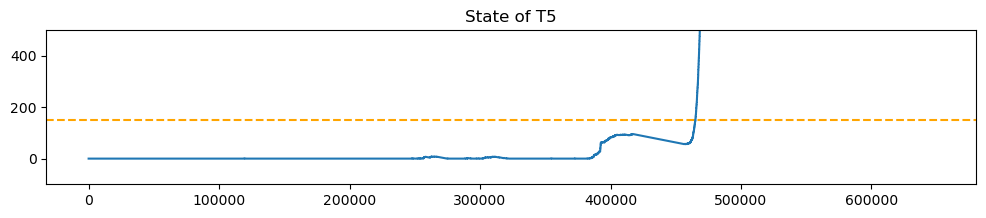

In [52]:
state_t5 = health_index(scores_t5, th=0.5, increase_step=1, decrease_step=0.001)

plt.figure(figsize=(12, 2))
plt.plot(state_t5)
plt.ylim(-100, 500)
plt.axhline(y=150, linestyle='--', c='orange')  # Health index에서 normal vs anomaly `threshold = 100`으로 설정
plt.title(f'State of T5')
plt.show()

In [56]:
predicted_labels = np.where(np.array(state_t5)>150, 1, 0)
predicted_labels  # 예측 라벨

array([0, 0, 0, ..., 1, 1, 1])

In [57]:
# 데이터 길이에 맞게 tool wear 값 interpolate & 라벨링
Tnum = 'T5'
toolwear_df = pd.read_csv(os.path.join(dir_path, Tnum, f'{Tnum}_all_labels.csv'))

index = toolwear_df.index
toolwear = toolwear_df['Tool Wear in (µm)'].values

f_nearest = interp1d(index, toolwear, kind='nearest')

index_new = np.linspace(index.min(), index.max(), len(scores_t5))
toolwear_new = f_nearest(index_new)

# tool wear 값 250 이상이면 anomaly
labels = np.where(toolwear_new>=250, 1, 0)
labels  # 실제 라벨

array([0, 0, 0, ..., 1, 1, 1])

In [58]:
# 평가 지표 계산
accuracy = accuracy_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels)
recall = recall_score(labels, predicted_labels)
f1 = f1_score(labels, predicted_labels)
conf_matrix = confusion_matrix(labels, predicted_labels)

# 결과 출력
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.95
Precision: 0.83
Recall: 1.00
F1-Score: 0.91
Confusion Matrix:
[[465030  31096]
 [     0 151874]]
